In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cat /proc/meminfo | grep MemTotal
!df -h /content
!cp "/content/drive/MyDrive/DM/basic.csv" /content/basic.csv
!cp "/content/drive/MyDrive/DM/vahc.csv" /content/vahc.csv
!cp "/content/drive/MyDrive/DM/extended.csv" /content/extended.csv


MemTotal:       13286772 kB
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   57G   52G  53% /


In [ ]:
!pip install -q duckdb pyarrow

In [ ]:
import duckdb,gc,sys, pandas as pd, numpy as np, matplotlib.pyplot as plt
basic_csv = '/content/basic.csv'
vahc_csv  = '/content/vahc.csv'
ext_csv='/content/extended.csv'

#EDA

In [ ]:
def combine_csvs_by_row_simple(basic_csv, ext_csv, vahc_csv,
                               basic_keep=None, ext_keep=None, vahc_keep=None,
                               verbose=True):

    con = duckdb.connect(database=':memory:')
    try:
        if basic_keep is None:
            basic_keep = ['id','Mvir','Rvir','rs','vrms','x','y','z','vx','vy','vz','Mpeak','Vpeak','b1']
        if ext_keep is None:
            ext_keep = ['Orig_halo_ID','Spin','Spin_Bullock','b_to_a','c_to_a','Xoff','Voff','Acc_Rate_Inst','Acc_Rate_100Myr']
        if vahc_keep is None:
            vahc_keep = ['haloID','lam1_R4R200b','lam2_R4R200b','lam3_R4R200b','lam1_R2R200b','lam3_R2R200b']

        def q(name):
            return '"' + name.replace('"','""') + '"'
        basic_cols_cte = ", ".join([q(c) for c in basic_keep])
        ext_cols_cte   = ", ".join([q(c) for c in ext_keep])
        vahc_cols_cte  =", ".join([q(c) for c in vahc_keep])
        basic_cols_outer= ", ".join([f"b.{q(c)}" for c in basic_keep])
        ext_cols_outer  = ", ".join([f"e.{q(c)}" for c in ext_keep])
        vahc_cols_outer= ", ".join([f"v.{q(c)}" for c in vahc_keep])
        sql = f"""
        WITH
          basic AS (
             SELECT {basic_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{basic_csv}')
          ),
          ext AS (
             SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{ext_csv}')
          ),
          vahc AS (
             SELECT {vahc_cols_cte}, ROW_NUMBER() OVER () AS rn
             FROM read_csv_auto('{vahc_csv}')
          )
        SELECT
          {basic_cols_outer},
          {ext_cols_outer},
          {vahc_cols_outer}
        FROM basic b
        LEFT JOIN ext   e ON b.rn = e.rn
        LEFT JOIN vahc  v ON b.rn = v.rn
        ;
        """

        if verbose:
            print("Running DuckDB query to load selected columns and join by row number...")
        df = con.execute(sql).df()

        if verbose:
            print("Loaded shape:", df.shape)
            print("Columns:", df.columns.tolist())

        return df

    finally:
        try:
            con.close()
        except:
            pass
        gc.collect()

df = combine_csvs_by_row_simple('basic.csv', 'extended.csv', 'vahc.csv', verbose=True)


Running DuckDB query to load selected columns and join by row number...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded shape: (10549241, 29)
Columns: ['id', 'Mvir', 'Rvir', 'rs', 'vrms', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Mpeak', 'Vpeak', 'b1', 'Orig_halo_ID', 'Spin', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'Xoff', 'Voff', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'haloID', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b', 'lam1_R2R200b', 'lam3_R2R200b']


In [ ]:
df.head()

,id,Mvir,Rvir,rs,vrms,x,y,z,vx,vy,...,Xoff,Voff,Acc_Rate_Inst,Acc_Rate_100Myr,haloID,lam1_R4R200b,lam2_R4R200b,lam3_R4R200b,lam1_R2R200b,lam3_R2R200b
0,1310204287,3.690000e+14,1455.176,347.786,1205.54,32.51410,18.76534,34.81572,-12.91,408.24,...,149.4810,242.88,69560.0,69560.0,1310204287,3.771847,4.403918,5.291896,21.157839,26.283495
1,1310192416,3.637000e+14,1448.118,1121.843,1140.66,32.83216,34.71375,28.81610,449.72,4.82,...,300.8370,366.86,215000.0,215000.0,1310192416,3.456567,4.418976,5.875593,17.634478,28.191383
2,1310193415,2.640000e+14,1301.423,408.964,1092.24,33.51439,35.39557,27.85350,-281.37,-313.82,...,217.1460,599.61,46980.0,46980.0,1310193415,5.623648,6.870534,8.379129,29.079180,43.500343
3,1310219719,1.669000e+14,1117.072,239.855,1015.97,30.73376,26.87315,33.39271,-74.96,-173.40,...,97.9649,418.01,9938.0,9938.0,1310219719,1.349161,5.699795,7.524177,18.848068,30.927004
4,1310214330,1.621000e+14,1106.100,112.604,971.01,11.01126,19.40722,1.10470,200.55,-42.51,...,18.9992,29.37,8131.0,8131.0,1310214330,3.966265,5.650493,6.916995,20.047516,33.209780


In [ ]:
df.columns

Index(['id', 'Mvir', 'Rvir', 'rs', 'vrms', 'x', 'y', 'z', 'vx', 'vy', 'vz',
       'Mpeak', 'Vpeak', 'b1', 'Orig_halo_ID', 'Spin', 'Spin_Bullock',
       'b_to_a', 'c_to_a', 'Xoff', 'Voff', 'Acc_Rate_Inst', 'Acc_Rate_100Myr',
       'haloID', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b',
       'lam1_R2R200b', 'lam3_R2R200b'],
      dtype='object')

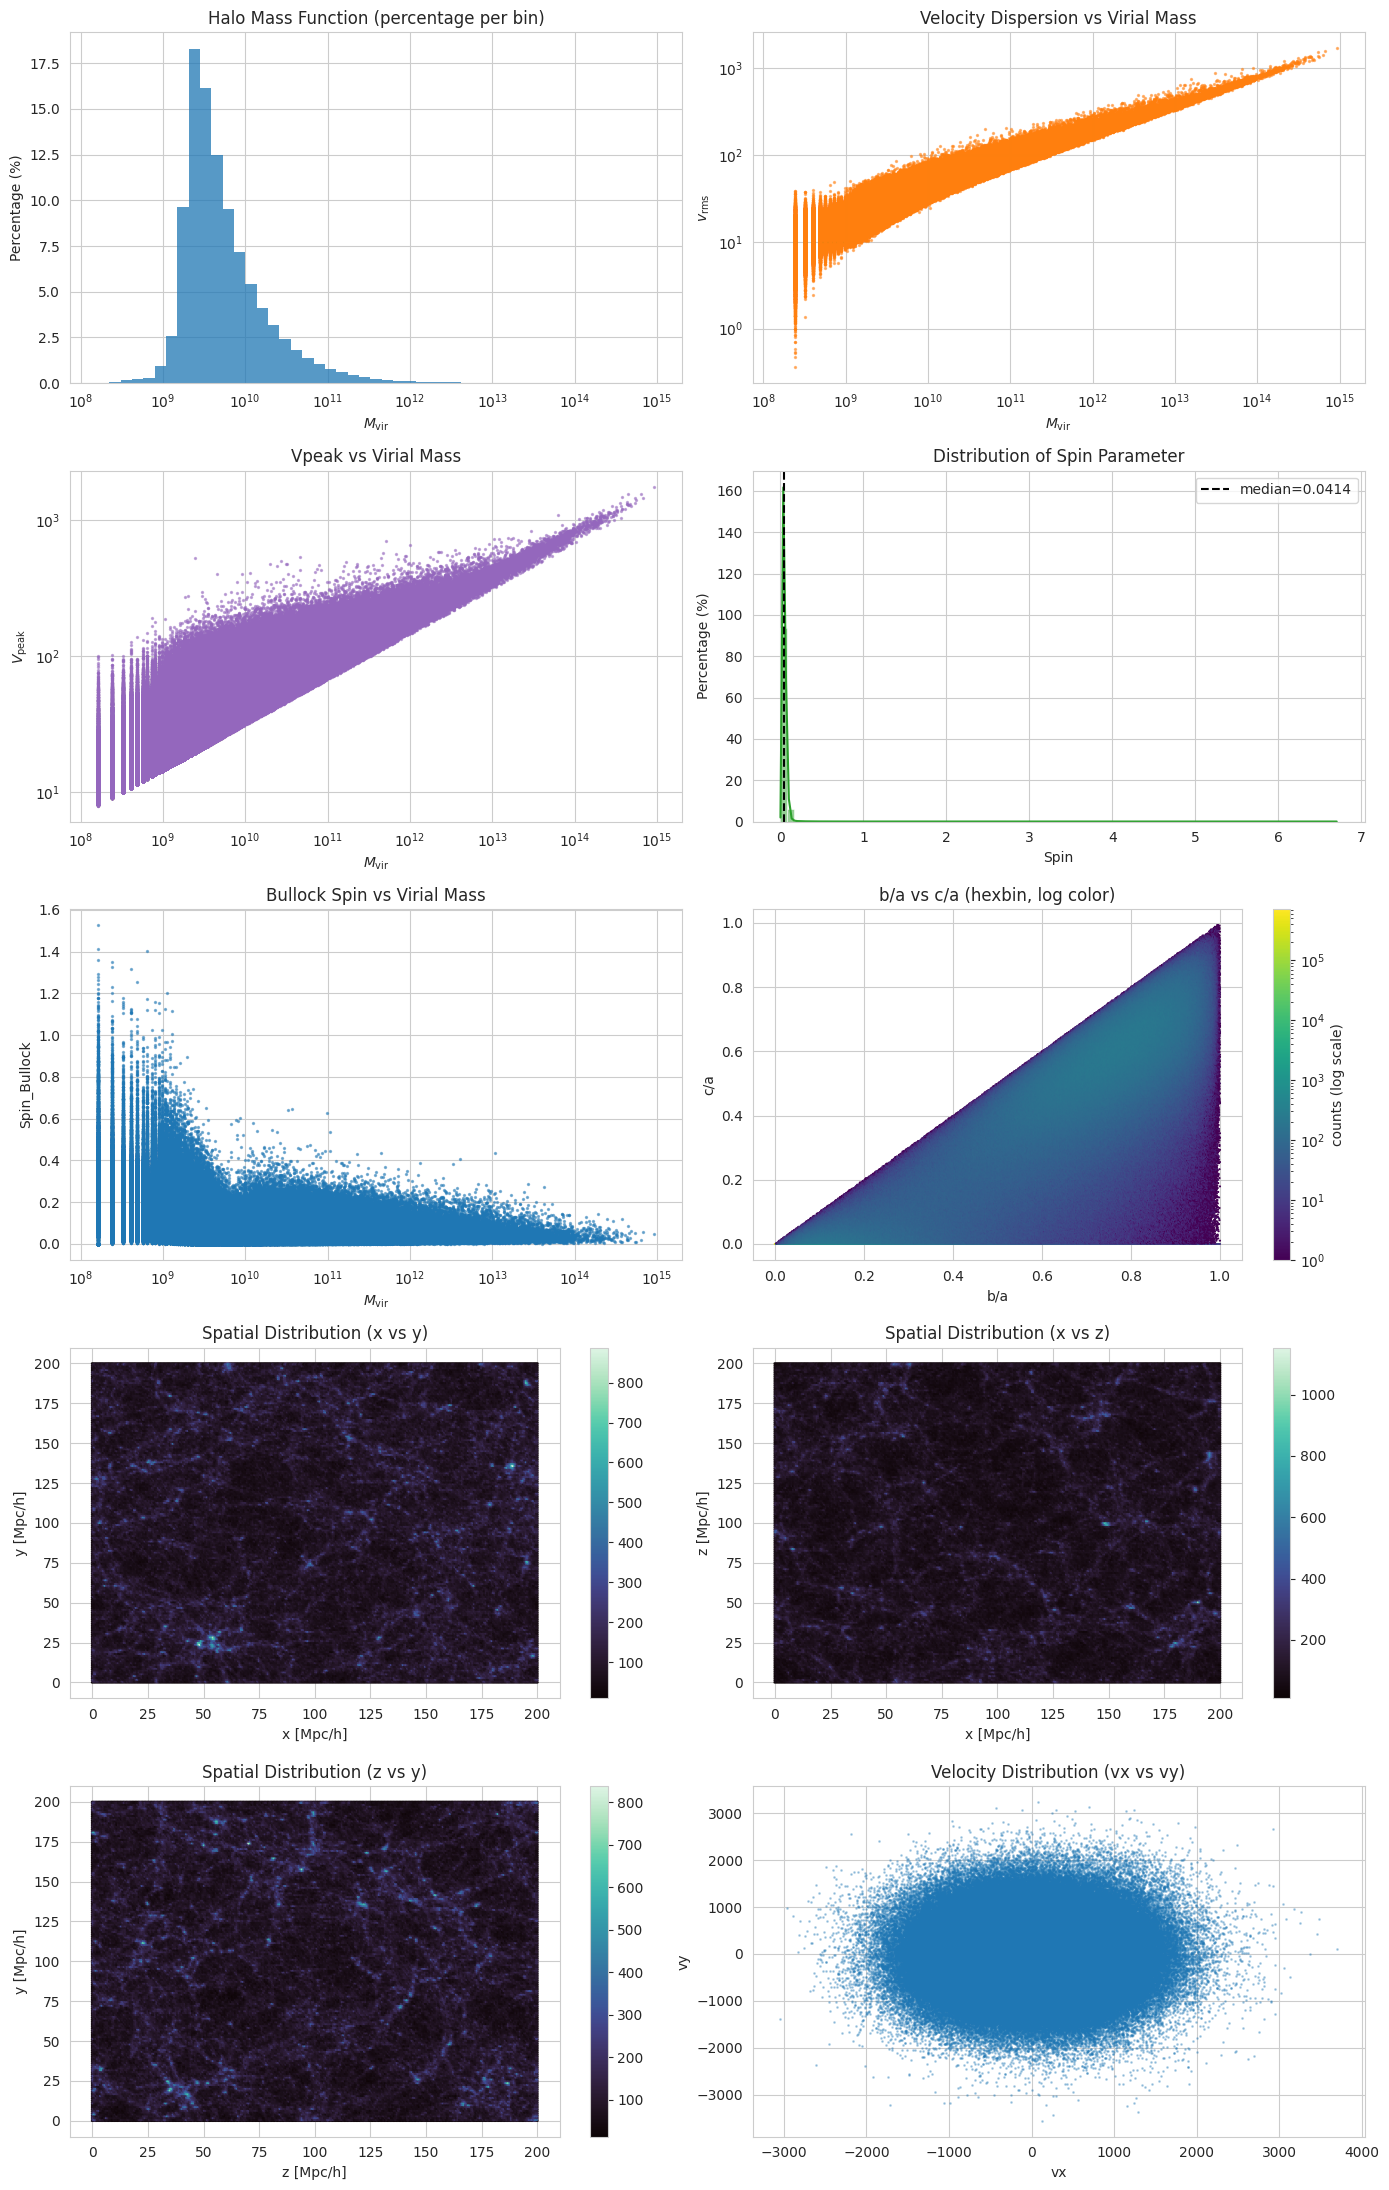

In [ ]:
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('whitegrid')
def plot(df):
    D = df
    fig, axes = plt.subplots(5, 2, figsize=(14, 22))
    axes = axes.flatten()

    #1)Mass function (percentage)
    masses = D['Mvir'].dropna().values
    bins = np.logspace(np.log10(masses.min()), np.log10(masses.max()), 50)
    sns.histplot(masses, bins=bins, stat='percent', ax=axes[0])
    axes[0].set_xscale('log')
    axes[0].set_xlabel(r"$M_{\rm vir}$"); axes[0].set_ylabel("Percentage (%)")
    axes[0].set_title("Halo Mass Function (percentage per bin)")
    #2)vrms vs Mvir
    axes[1].scatter(D['Mvir'], D['vrms'], s=2, alpha=0.5, c="tab:orange")
    axes[1].set_xscale("log"); axes[1].set_yscale("log")
    axes[1].set_xlabel(r"$M_{\rm vir}$"); axes[1].set_ylabel(r"$v_{\rm rms}$")
    axes[1].set_title("Velocity Dispersion vs Virial Mass")
    #3)Vpeak vs Mvir
    axes[2].scatter(D['Mvir'], D['Vpeak'], s=2, alpha=0.5, c="tab:purple")
    axes[2].set_xscale("log"); axes[2].set_yscale("log")
    axes[2].set_xlabel(r"$M_{\rm vir}$"); axes[2].set_ylabel(r"$V_{\rm peak}$")
    axes[2].set_title("Vpeak vs Virial Mass")
    #4)Spin histogram (percent)
    sns.histplot(D['Spin'].dropna(), bins=80, kde=True, stat='percent', color='tab:green', ax=axes[3])
    axes[3].axvline(np.nanmedian(D['Spin'].dropna()), color='k', linestyle='--',
                    label=f"median={np.nanmedian(D['Spin'].dropna()):.3g}")
    axes[3].set_xlabel("Spin"); axes[3].set_ylabel("Percentage (%)")
    axes[3].set_title("Distribution of Spin Parameter")
    axes[3].legend()
    #5)Bullock spin vs Mass
    axes[4].scatter(D['Mvir'], D['Spin_Bullock'], s=2, alpha=0.5)
    axes[4].set_xscale('log')
    axes[4].set_xlabel(r"$M_{\rm vir}$"); axes[4].set_ylabel("Spin_Bullock")
    axes[4].set_title("Bullock Spin vs Virial Mass")
    #6)Axis ratios b/a vs c/a (hexbin, log color)
    hb = axes[5].hexbin(df['b_to_a'], df['c_to_a'], gridsize=500, mincnt=1,
                        cmap='viridis', norm=LogNorm())
    fig.colorbar(hb, ax=axes[5], label='counts (log scale)')
    axes[5].set_xlabel('b/a'); axes[5].set_ylabel('c/a')
    axes[5].set_title('b/a vs c/a (hexbin, log color)')
    #7)Spatial (x vs y)
    pts = D[['x','y']].dropna().values
    hb2 = axes[6].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb2, ax=axes[6])
    axes[6].set_xlabel('x [Mpc/h]'); axes[6].set_ylabel('y [Mpc/h]')
    axes[6].set_title('Spatial Distribution (x vs y)')
    #8)Spatial (x vs z)
    pts = D[['x','z']].dropna().values
    hb3 = axes[7].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb3, ax=axes[7])
    axes[7].set_xlabel('x [Mpc/h]'); axes[7].set_ylabel('z [Mpc/h]')
    axes[7].set_title('Spatial Distribution (x vs z)')
    #9)Spatial (z vs y)
    pts=D[['z','y']].dropna().values
    hb4=axes[8].hexbin(pts[:,0], pts[:,1], gridsize=300, cmap='mako', mincnt=1)
    fig.colorbar(hb4, ax=axes[8])
    axes[8].set_xlabel('z [Mpc/h]'); axes[8].set_ylabel('y [Mpc/h]')
    axes[8].set_title('Spatial Distribution (z vs y)')
    #10)Velocity scatter (vx vs vy)
    sel = D[['vx','vy']].dropna()
    axes[9].scatter(sel['vx'], sel['vy'], s=1, alpha=0.3)
    axes[9].set_xlabel('vx'); axes[9].set_ylabel('vy')
    axes[9].set_title('Velocity Distribution (vx vs vy)')

    plt.tight_layout()
    plt.show()
plot(df)


# Reproducing Sujatha et. al. 2019

In [ ]:
nbins=10
bins_to_do=[0,1,2,3,4,5,6,7,8,9]
basic_keep =['Mvir','Rvir','rs','b1']
vahc_keep  =['lam1_R4R200b','lam2_R4R200b','lam3_R4R200b']
ext_keep   =['Jx','Jy','Jz','Spin','Spin_Bullock','b_to_a','c_to_a']
con = duckdb.connect()
def q(name):
    return '"' + name.replace('"','""') + '"'

basic_cols_cte= ', '.join([q(c) for c in basic_keep])
vahc_cols_cte= ', '.join([q(c) for c in vahc_keep]) if vahc_keep else ''
ext_cols_cte= ', '.join([q(c) for c in ext_keep])  if ext_keep  else ''

minmax=con.execute(f"""
    SELECT MIN(LOG10({q('Mvir')}::DOUBLE)) AS minlog,
           MAX(LOG10({q('Mvir')}::DOUBLE)) AS maxlog
    FROM read_csv_auto('{basic_csv}')
""").fetchdf()
minlog=float(minmax.loc[0,'minlog'])
maxlog=float(minmax.loc[0,'maxlog'])

sql=f"""
WITH basic AS (
  SELECT {basic_cols_cte},
         LOG10({q('Mvir')}::DOUBLE) AS logMvir,
         ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{basic_csv}')
),
vahc AS (
  SELECT {vahc_cols_cte}, ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{vahc_csv}')
),
extended AS (
  SELECT {ext_cols_cte}, ROW_NUMBER() OVER () AS rn
  FROM read_csv_auto('{ext_csv}')
),
joined AS (
  SELECT
    b.{q('Mvir')}, b.{q('Rvir')}, b.{q('rs')}, b.{q('b1')}, b.logMvir
    { (', v.' + ', v.'.join([q(c) for c in vahc_keep])) if vahc_keep else '' }
    { (', e.' + ', e.'.join([q(c) for c in ext_keep]))  if ext_keep  else '' },
    CAST(
      LEAST(
        GREATEST(
          FLOOR( ((b.logMvir - {minlog}) / ({maxlog} - {minlog})) * {nbins} ),
          0
        ),
        {nbins}-1
      ) AS INTEGER
    ) AS mbin
  FROM basic b
  LEFT JOIN vahc v ON b.rn = v.rn
  LEFT JOIN extended e ON b.rn = e.rn
  WHERE b.{q('Mvir')} IS NOT NULL
)
SELECT *
FROM joined
WHERE mbin IN ({','.join(map(str,bins_to_do))});
"""
try:
    df = con.execute(sql).df()
except Exception as e:
    print("=== DuckDB error ===")
    print(e)
    print("\n--- SQL ---\n", sql)
    con.close()
    raise

con.close()

print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())
con=duckdb.connect()
ct_basic=int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{basic_csv}')").fetchdf().iloc[0,0])
ct_vahc=int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{vahc_csv}')").fetchdf().iloc[0,0])
ct_ext= int(con.execute(f"SELECT COUNT(*) FROM read_csv_auto('{ext_csv}')").fetchdf().iloc[0,0])
con.close()
print("Counts (basic, vahc, ext):", ct_basic, ct_vahc, ct_ext)
print("Rows loaded into pandas:", len(df))
display(df.head())
display(df.tail())
gc.collect()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded dataframe shape: (10549241, 16)
Columns: ['Mvir', 'Rvir', 'rs', 'b1', 'logMvir', 'lam1_R4R200b', 'lam2_R4R200b', 'lam3_R4R200b', 'Jx', 'Jy', 'Jz', 'Spin', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'mbin']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Counts (basic, vahc, ext): 10549241 10549241 10549241
Rows loaded into pandas: 10549241


,Mvir,Rvir,rs,b1,logMvir,lam1_R4R200b,lam2_R4R200b,lam3_R4R200b,Jx,Jy,Jz,Spin,Spin_Bullock,b_to_a,c_to_a,mbin
0,3.690000e+14,1455.176,347.786,8.804691,14.567026,3.771847,4.403918,5.291896,-1.593000e+15,-1.223000e+16,2.673000e+16,0.03065,0.03711,0.53878,0.37788,9
1,3.637000e+14,1448.118,1121.843,6.174762,14.560743,3.456567,4.418976,5.875593,-8.927000e+15,3.993000e+16,-6.612000e+15,0.03584,0.05355,0.82220,0.67789,9
2,2.640000e+14,1301.423,408.964,6.028630,14.421604,5.623648,6.870534,8.379129,2.342000e+15,2.324000e+16,2.347000e+16,0.02989,0.07296,0.40686,0.28477,9
3,1.669000e+14,1117.072,239.855,7.745976,14.222456,1.349161,5.699795,7.524177,1.450000e+14,3.183000e+15,-1.414000e+15,0.01158,0.01649,0.35997,0.30630,8
4,1.621000e+14,1106.100,112.604,4.474640,14.209783,3.966265,5.650493,6.916995,-1.761000e+15,1.376000e+15,3.109000e+15,0.01924,0.01903,0.83051,0.49211,8


,Mvir,Rvir,rs,b1,logMvir,lam1_R4R200b,lam2_R4R200b,lam3_R4R200b,Jx,Jy,Jz,Spin,Spin_Bullock,b_to_a,c_to_a,mbin
10549236,162200000.0,11.064,2.341,-5.772792,8.210051,0.0,0.0,0.0,-7503000.0,-3476000.0,-6273000.0,0.82433,0.51517,0.0,0.0,0
10549237,162200000.0,11.064,1.324,-4.723429,8.210051,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0
10549238,162200000.0,11.064,1.350,-5.282835,8.210051,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0
10549239,162200000.0,11.064,3.686,-3.613937,8.210051,0.0,0.0,0.0,-521000.0,1708000.0,-2834000.0,0.20073,0.16625,0.0,0.0,0
10549240,162200000.0,11.064,3.304,-4.801786,8.210051,0.0,0.0,0.0,-2717000.0,10090000.0,-10690000.0,1.35937,0.74207,0.0,0.0,0


62

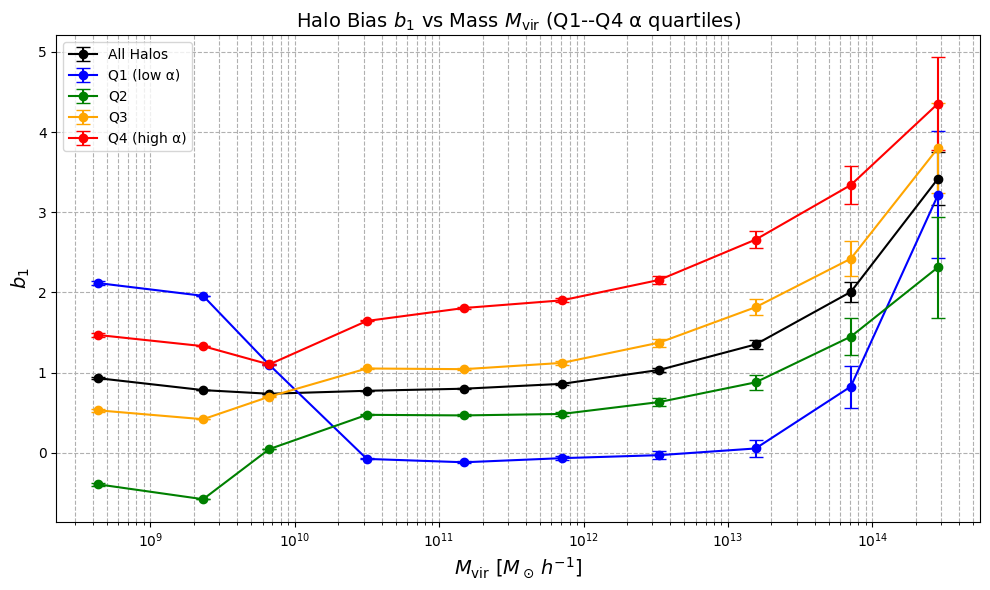

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: alpha_min = 0, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0
   Q4: alpha_min = 0, alpha_max = 0.709777

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: alpha_min = -27.565, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0
   Q4: alpha_min = 0, alpha_max = 3.85712

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: alpha_min = -786235, alpha_max = 0
   Q2: alpha_min = 0, alpha_max = 0
   Q3: alpha_min = 0, alpha_max = 0.476344
   Q4: alpha_min = 0.476344, alpha_max = 130384

bin 3: total=1108967 halos; clea

In [ ]:
def run_cell():
    df1 = df.copy()
    df1['logMvir'] = np.log10(df1['Mvir'].astype(float))
    df1['trace'] = df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] = 0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] = df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])
    grouped = df1.groupby('mbin')
    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()

    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)

    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q = {q: [] for q in quartile_names}
    b1_mean_q = {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin = {}
    alpha_range_per_bin = {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            alpha_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        clean = bin_df[['alpha','logMvir','b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['alpha']).copy()
        n_clean = len(clean)

        if n_clean == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            alpha_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order = np.argsort(clean['alpha'].values, kind='stable')
        sorted_idx = clean.index.values[order]

        base = n_clean // 4
        rem = n_clean % 4
        sizes = [base + (1 if i < rem else 0) for i in range(4)]
        edges = np.cumsum([0] + sizes)

        q_masks = {}
        for i, qname in enumerate(quartile_names):
            lo, hi = edges[i], edges[i+1]
            sel_idx = sorted_idx[lo:hi]
            q_masks[qname] = bin_df.index.isin(sel_idx)

        counts_per_bin[mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
        alpha_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                alpha_min, alpha_max = np.nan, np.nan
            else:
                a_clean = qdf['alpha'].replace([np.inf, -np.inf], np.nan).dropna()
                alpha_min = a_clean.min() if len(a_clean) else np.nan
                alpha_max = a_clean.max() if len(a_clean) else np.nan
            alpha_range_per_bin[mbin][qname] = (alpha_min, alpha_max)

        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q] = (np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors = {'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels = {'Q1': 'Q1 (low α)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high α)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 α quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total = len(df1[df1['mbin'] == mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            amin, amax = alpha_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: alpha_min = {np.nan if np.isnan(amin) else format(amin, '.6g')}, "
                  f"alpha_max = {np.nan if np.isnan(amax) else format(amax, '.6g')}")

output = run_cell()

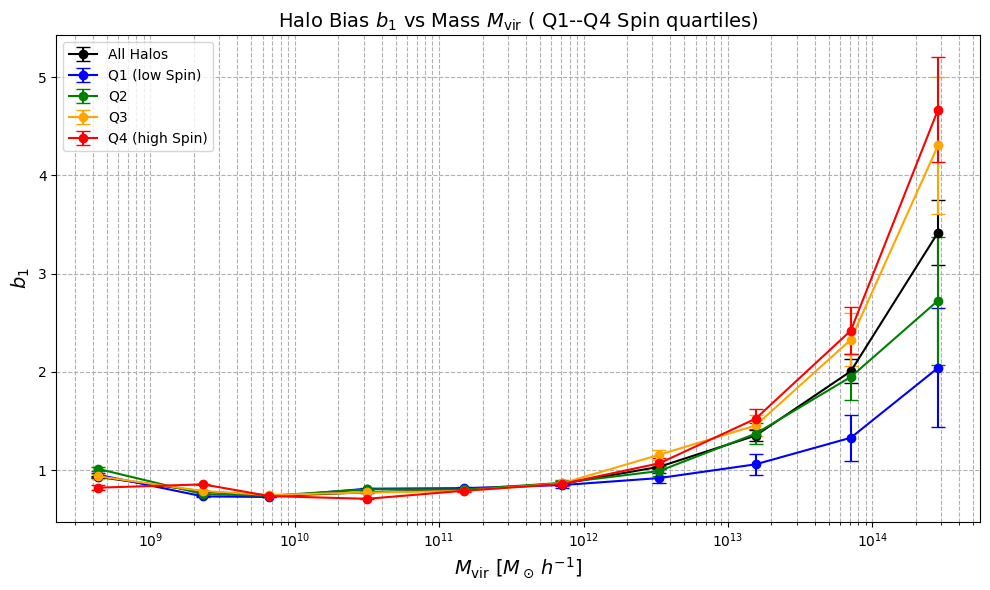

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

 bin 0: total=89962 halos; quartiles -> Q1=22496, Q2=22485, Q3=22490, Q4=22491
   Q1: Spin_min = 0, Spin_max = 0.03352
   Q2: Spin_min = 0.03353, Spin_max = 0.07678
   Q3: Spin_min = 0.07679, Spin_max = 0.20541
   Q4: Spin_min = 0.20542, Spin_max = 6.70428

 bin 1: total=4706881 halos; quartiles -> Q1=1177157, Q2=1177065, Q3=1175998, Q4=1176661
   Q1: Spin_min = 5e-05, Spin_max = 0.03043
   Q2: Spin_min = 0.03044, Spin_max = 0.0445
   Q3: Spin_min = 0.04451, Spin_max = 0.0613
   Q4: Spin_min = 0.06131, Spin_max = 3.71418

 bin 2: total=4271456 halos; quartiles -> Q1=1068193, Q2=1068212, Q3=1067557, Q4=1067494
   Q1: Spin_min = 0.00013, Spin_max = 0.02762
   Q2: Spin_min = 0.02763, Spin_max = 0.03983
   Q3: Spin_min = 0.03984, Spin_max = 0.05482
   Q4: Spin_min = 0.05483, Spin_max = 0.96052

 bin 3: total=1108967 halos; quartiles -> Q1=27731

In [ ]:
def run_cell():
    df1=df.copy()
    grouped=df1.groupby('mbin')

    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all = m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all=b1_sem_all.reindex(m_mean_all.index)
    quartile_names=['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q={q: [] for q in quartile_names}
    b1_mean_q={q: [] for q in quartile_names}
    b1_sem_q ={q: [] for q in quartile_names}
    mbin_list_for_plot = []
    counts_per_bin ={}
    spin_range_per_bin= {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin']==mbin]
        if len(bin_df)==0:
            counts_per_bin[mbin]={q: 0 for q in quartile_names}
            spin_range_per_bin[mbin]={q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        q1, q2, q3=np.quantile(bin_df['Spin'].values, [0.25, 0.5, 0.75])
        masks = {
            'Q1': bin_df['Spin'] <= q1,
            'Q2': (bin_df['Spin'] > q1) & (bin_df['Spin'] <= q2),
            'Q3': (bin_df['Spin'] > q2) & (bin_df['Spin'] <= q3),
            'Q4': bin_df['Spin'] > q3
        }
        counts_per_bin[mbin]={q: int(masks[q].sum()) for q in quartile_names}
        spin_range_per_bin[mbin]={}
        for qname in quartile_names:
            qdf = bin_df[masks[qname]]
            if len(qdf)==0:
                spin_min=np.nan
                spin_max=np.nan
            else:
                s_clean=qdf['Spin'].replace([np.inf, -np.inf], np.nan).dropna()
                if len(s_clean)==0:
                    spin_min=np.nan
                    spin_max = np.nan
                else:
                    spin_min=s_clean.min()
                    spin_max=s_clean.max()
            spin_range_per_bin[mbin][qname] = (spin_min, spin_max)

        for qname in quartile_names:
            qdf=bin_df[masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(x_all[i])
                ym.append(bval)
                em.append(err)
        plot_data[q]=(np.array(xm), np.array(ym), np.array(em))

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors={'Q1':'blue','Q2':'green','Q3':'orange','Q4':'red'}
    labels={'Q1':'Q1 (low Spin)', 'Q2':'Q2', 'Q3':'Q3', 'Q4':'Q4 (high Spin)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])
    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ ( Q1--Q4 Spin quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n=len(df1[df1['mbin']==mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\n bin {mbin}: total={n:4d} halos; quartiles -> " +
              ", ".join([f"{q}={qcounts[q]:3d}" for q in quartile_names]))
        for q in quartile_names:
            smin, smax = spin_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: Spin_min = {np.nan if np.isnan(smin) else format(smin, '.6g')}, "
                  f"Spin_max = {np.nan if np.isnan(smax) else format(smax, '.6g')}")
    del df1
    gc.collect()

output = run_cell()

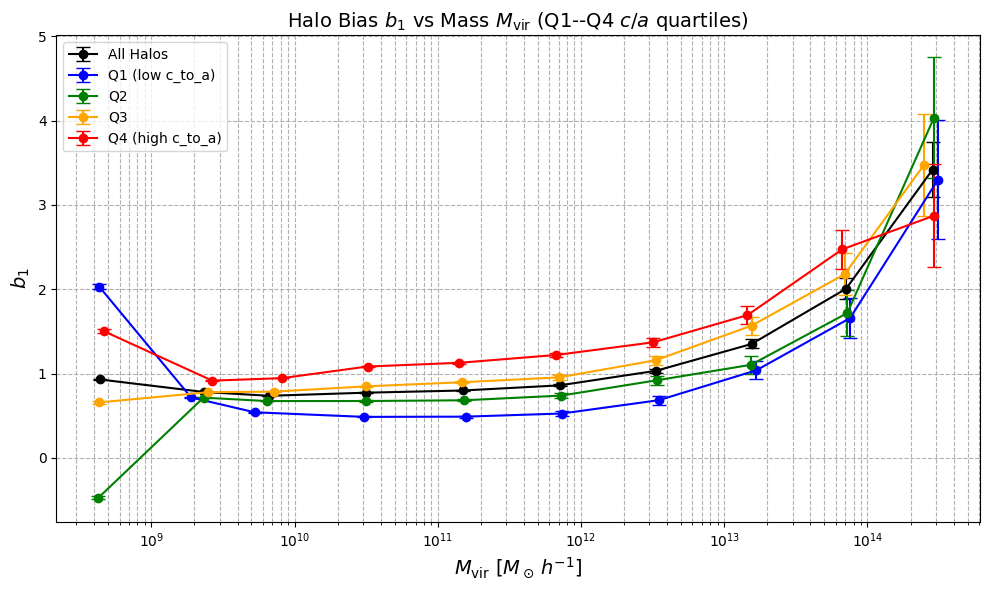

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: c_to_a_min = 0, c_to_a_max = 0
   Q2: c_to_a_min = 0, c_to_a_max = 0
   Q3: c_to_a_min = 0, c_to_a_max = 0
   Q4: c_to_a_min = 0, c_to_a_max = 0.84861

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: c_to_a_min = 0, c_to_a_max = 0.02547
   Q2: c_to_a_min = 0.02547, c_to_a_max = 0.17922
   Q3: c_to_a_min = 0.17922, c_to_a_max = 0.39184
   Q4: c_to_a_min = 0.39184, c_to_a_max = 0.98413

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: c_to_a_min = 0, c_to_a_max = 0.37002
   Q2: c_to_a_min = 0.37002, c_to_a_max = 0.50989
   Q3: c_to_a_min = 0.50989, c_to_a_max = 0.62613
   Q4: c_to_a

In [ ]:
def run_cell():
    df1=df.copy()
    df1['logMvir']=np.log10(df1['Mvir'].astype(float))
    df1['trace']=df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2']=0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta'] =df1['trace']
    df1['alpha'] = np.sqrt(df1['q2']) / (1 + df1['delta'])
    grouped = df1.groupby('mbin')
    m_mean_all =(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all= grouped['b1'].mean().dropna()
    b1_count_all= grouped['b1'].count()
    b1_sem_all=(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all =m_mean_all.sort_index()
    b1_mean_all=b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all= b1_sem_all.reindex(m_mean_all.index)
    quartile_names =['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q ={q: [] for q in quartile_names}
    b1_mean_q= {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot =[]
    counts_per_bin ={}
    c_to_a_range_per_bin= {}
    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            c_to_a_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue
        clean=bin_df[['c_to_a', 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['c_to_a']).copy()
        n_clean=len(clean)
        if n_clean== 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            c_to_a_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order=np.argsort(clean['c_to_a'].values, kind='stable')
        sorted_idx=clean.index.values[order]


        base=n_clean // 4
        rem=n_clean % 4
        sizes=[base + (1 if i < rem else 0) for i in range(4)]
        edges=np.cumsum([0] + sizes)

        q_masks ={}
        for i, qname in enumerate(quartile_names):
            lo, hi= edges[i], edges[i+1]
            sel_idx= sorted_idx[lo:hi]
            q_masks[qname]= bin_df.index.isin(sel_idx)
        counts_per_bin[mbin]={q: int(q_masks[q].sum()) for q in quartile_names}
        c_to_a_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf=bin_df[q_masks[qname]]
            if len(qdf)==0:
                cmin, cmax=np.nan, np.nan
            else:
                cleanvals =qdf['c_to_a'].replace([np.inf, -np.inf], np.nan).dropna()
                cmin =cleanvals.min() if len(cleanvals) else np.nan
                cmax =cleanvals.max() if len(cleanvals) else np.nan
            c_to_a_range_per_bin[mbin][qname]=(cmin, cmax)

        for qname in quartile_names:
            qdf=bin_df[q_masks[qname]]
            if len(qdf)== 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))
    plot_data={}
    for q in quartile_names:
        xm, ym, em=[], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval=m_mean_q[q][i]
            bval=b1_mean_q[q][i]
            err =b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(mval)
                ym.append(bval)
                em.append(err)
        plot_data[q] =(np.array(xm), np.array(ym), np.array(em))


    x_all =m_mean_all.loc[mbin_list_for_plot].values
    y_all= b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all=b1_sem_all.loc[mbin_list_for_plot].values
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors ={'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels ={'Q1': 'Q1 (low c_to_a)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high c_to_a)'}
    for q in quartile_names:
        xm, ym, em= plot_data[q]
        if len(xm)> 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 $c/a$ quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total =len(df1[df1['mbin'] == mbin])
        qcounts =counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            cmin, cmax = c_to_a_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: c_to_a_min = {np.nan if np.isnan(cmin) else format(cmin, '.6g')}, "
                  f"c_to_a_max = {np.nan if np.isnan(cmax) else format(cmax, '.6g')}")
    del df1
    gc.collect()
output=run_cell()


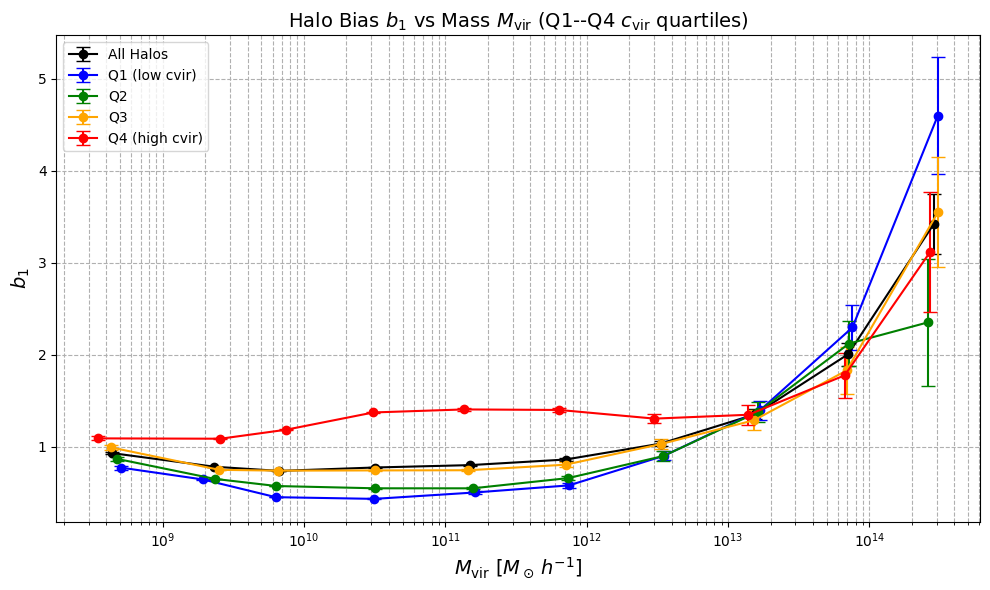

Processed bins: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]

bin 0: total= 89962 halos; cleaned_for_sorting= 89962; quartiles -> Q1=22491, Q2=22491, Q3=22490, Q4=22490
   Q1: cvir_min = 2.17, cvir_max = 3.57163
   Q2: cvir_min = 3.57169, cvir_max = 4.75247
   Q3: cvir_min = 4.75258, cvir_max = 6.89505
   Q4: cvir_min = 6.89517, cvir_max = 55.0207

bin 1: total=4706881 halos; cleaned_for_sorting=4706881; quartiles -> Q1=1176721, Q2=1176720, Q3=1176720, Q4=1176720
   Q1: cvir_min = 2.16255, cvir_max = 7.04106
   Q2: cvir_min = 7.04106, cvir_max = 11.1593
   Q3: cvir_min = 11.1593, cvir_max = 16.3302
   Q4: cvir_min = 16.3302, cvir_max = 131.078

bin 2: total=4271456 halos; cleaned_for_sorting=4271456; quartiles -> Q1=1067864, Q2=1067864, Q3=1067864, Q4=1067864
   Q1: cvir_min = 1.00359, cvir_max = 10.9398
   Q2: cvir_min = 10.9398, cvir_max = 14.9372
   Q3: cvir_min = 14.9372, cvir_max = 20.4109
   Q4:

In [ ]:
def run_cell():
    df1 = df.copy()
    df1['logMvir'] = np.log10(df1['Mvir'].astype(float))
    df1['cvir'] = df1['Rvir'].astype(float) / df1['rs'].astype(float)
    grouped = df1.groupby('mbin')

    m_mean_all = (10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all = grouped['b1'].mean().dropna()
    b1_count_all = grouped['b1'].count()
    b1_sem_all = (grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()

    m_mean_all = m_mean_all.sort_index()
    b1_mean_all = b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all = b1_sem_all.reindex(m_mean_all.index)

    quartile_names = ['Q1', 'Q2', 'Q3', 'Q4']
    m_mean_q = {q: [] for q in quartile_names}
    b1_mean_q = {q: [] for q in quartile_names}
    b1_sem_q = {q: [] for q in quartile_names}
    mbin_list_for_plot = []

    counts_per_bin = {}
    cvir_range_per_bin = {}

    for mbin in sorted(df1['mbin'].unique()):
        mbin_list_for_plot.append(mbin)
        bin_df = df1[df1['mbin'] == mbin]
        n_bin = len(bin_df)

        if n_bin == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            cvir_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        clean = bin_df[['cvir', 'logMvir', 'b1']].replace([np.inf, -np.inf], np.nan).dropna(subset=['cvir']).copy()
        n_clean = len(clean)

        if n_clean == 0:
            counts_per_bin[mbin] = {q: 0 for q in quartile_names}
            cvir_range_per_bin[mbin] = {q: (np.nan, np.nan) for q in quartile_names}
            for q in quartile_names:
                m_mean_q[q].append(np.nan)
                b1_mean_q[q].append(np.nan)
                b1_sem_q[q].append(np.nan)
            continue

        order = np.argsort(clean['cvir'].values, kind='stable')
        sorted_idx = clean.index.values[order]

        base = n_clean // 4
        rem = n_clean % 4
        sizes = [base + (1 if i < rem else 0) for i in range(4)]
        edges = np.cumsum([0] + sizes)

        q_masks = {}
        for i, qname in enumerate(quartile_names):
            lo, hi = edges[i], edges[i+1]
            sel_idx = sorted_idx[lo:hi]
            q_masks[qname] = bin_df.index.isin(sel_idx)

        counts_per_bin[mbin] = {q: int(q_masks[q].sum()) for q in quartile_names}
        cvir_range_per_bin[mbin] = {}
        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                cmin, cmax = np.nan, np.nan
            else:
                cleanvals = qdf['cvir'].replace([np.inf, -np.inf], np.nan).dropna()
                cmin = cleanvals.min() if len(cleanvals) else np.nan
                cmax = cleanvals.max() if len(cleanvals) else np.nan
            cvir_range_per_bin[mbin][qname] = (cmin, cmax)

        for qname in quartile_names:
            qdf = bin_df[q_masks[qname]]
            if len(qdf) == 0:
                m_mean_q[qname].append(np.nan)
                b1_mean_q[qname].append(np.nan)
                b1_sem_q[qname].append(np.nan)
            else:
                m_mean_q[qname].append(10 ** qdf['logMvir'].mean())
                b1_mean_q[qname].append(qdf['b1'].mean())
                b1_sem_q[qname].append(qdf['b1'].std() / np.sqrt(len(qdf)))

    plot_data = {}
    for q in quartile_names:
        xm, ym, em = [], [], []
        for i, mbin in enumerate(mbin_list_for_plot):
            mval = m_mean_q[q][i]
            bval = b1_mean_q[q][i]
            err = b1_sem_q[q][i]
            if not np.isnan(bval) and not np.isnan(mval):
                xm.append(mval)
                ym.append(bval)
                em.append(err)
        plot_data[q] = (np.array(xm), np.array(ym), np.array(em))

    x_all = m_mean_all.loc[mbin_list_for_plot].values
    y_all = b1_mean_all.loc[mbin_list_for_plot].values
    yerr_all = b1_sem_all.loc[mbin_list_for_plot].values

    plt.figure(figsize=(10, 6))
    plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o-', capsize=5, label='All Halos', color='black')

    colors = {'Q1': 'blue', 'Q2': 'green', 'Q3': 'orange', 'Q4': 'red'}
    labels = {'Q1': 'Q1 (low cvir)', 'Q2': 'Q2', 'Q3': 'Q3', 'Q4': 'Q4 (high cvir)'}
    for q in quartile_names:
        xm, ym, em = plot_data[q]
        if len(xm) > 0:
            plt.errorbar(xm, ym, yerr=em, fmt='o-', capsize=5, label=labels[q], color=colors[q])

    plt.xscale('log')
    plt.xlabel(r'$M_{\rm vir}\ [M_\odot\, h^{-1}]$', fontsize=14)
    plt.ylabel(r'$b_1$', fontsize=14)
    plt.title(r'Halo Bias $b_1$ vs Mass $M_{\rm vir}$ (Q1--Q4 $c_{\rm vir}$ quartiles)', fontsize=14)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Processed bins: {mbin_list_for_plot}")
    for mbin in mbin_list_for_plot:
        n_total = len(df1[df1['mbin'] == mbin])
        qcounts = counts_per_bin.get(mbin, {q: 0 for q in quartile_names})
        print(f"\nbin {mbin}: total={n_total:6d} halos; cleaned_for_sorting={sum(qcounts.values()):6d}; "
              + "quartiles -> " + ", ".join([f"{q}={qcounts[q]:4d}" for q in quartile_names]))
        for q in quartile_names:
            cmin, cmax = cvir_range_per_bin.get(mbin, {}).get(q, (np.nan, np.nan))
            print(f"   {q}: cvir_min = {np.nan if np.isnan(cmin) else format(cmin, '.6g')}, "
                  f"cvir_max = {np.nan if np.isnan(cmax) else format(cmax, '.6g')}")

    del df1
    gc.collect()

output = run_cell()

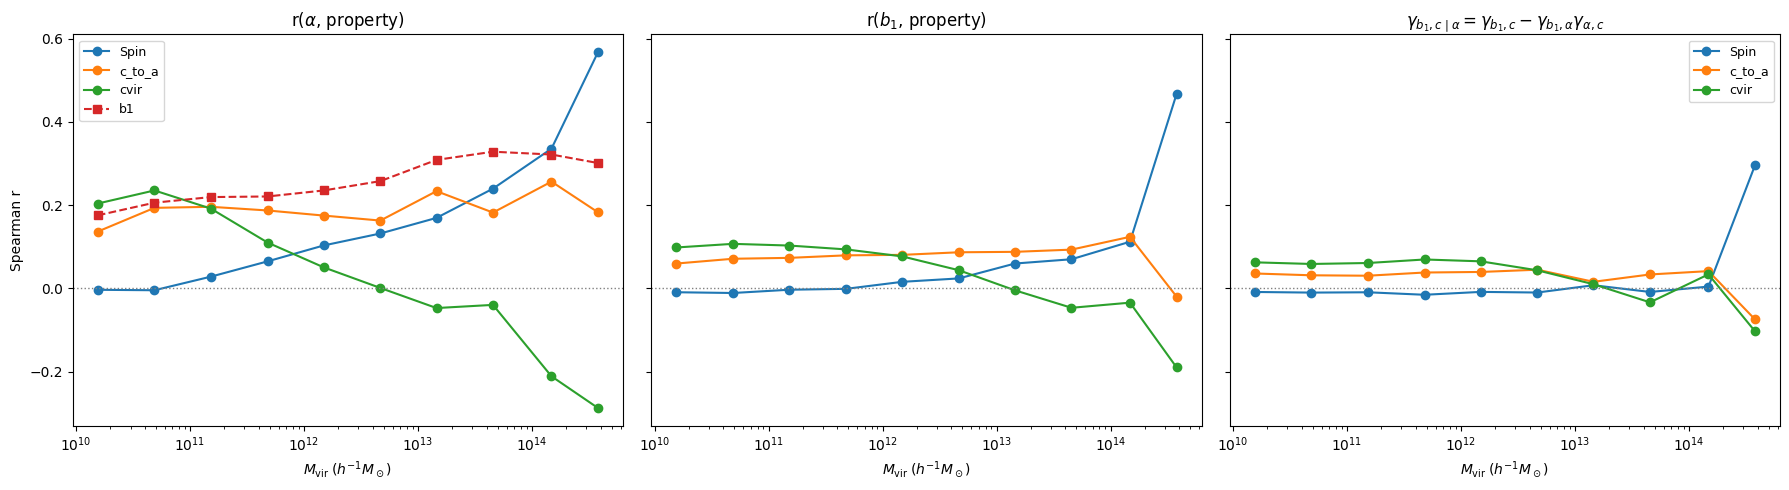

In [ ]:
def run_cell(min_n_for_stat=30, compute_normalized_partial=False):
    df1 =df.copy()

    if 'mbin' in df1.columns:
        df1= df1.drop(columns=['mbin'])
    df1['Mvir']= df1['Mvir'].astype(float)
    df1['logMvir']= np.log10(df1['Mvir'])

    df1['trace'] =df1['lam1_R4R200b'].astype(float) + df1['lam2_R4R200b'].astype(float) + df1['lam3_R4R200b'].astype(float)
    df1['q2'] =0.5 * (
        (df1['lam1_R4R200b'] - df1['lam2_R4R200b'])**2 +
        (df1['lam1_R4R200b'] - df1['lam3_R4R200b'])**2 +
        (df1['lam2_R4R200b'] - df1['lam3_R4R200b'])**2
    )
    df1['delta']= df1['trace']
    df1['alpha']= np.sqrt(df1['q2']) / (1 + df1['delta'])

    if 'cvir' not in df1.columns and ('Rvir' in df1.columns and 'rs' in df1.columns):
        df1['cvir']=df1['Rvir'].astype(float) / df1['rs'].astype(float)

    mass_cut =1e10
    df1 =df1[df1['Mvir'] > mass_cut].copy()

    if len(df1)== 0:
        raise RuntimeError("No halos left after mass cut Mvir > 1e10. Check your data or lower the cut.")

    logmin =df1['logMvir'].min()
    logmax =df1['logMvir'].max()
    edges =np.linspace(logmin, logmax, 11)
    df1['mbin']=pd.cut(df1['logMvir'], bins=edges, labels=False, include_lowest=True)
    df1=df1.dropna(subset=['mbin']).copy()
    df1['mbin']=df1['mbin'].astype(int)

    wanted=[('Spin','Spin'), ('c_to_a','c_to_a'), ('cvir','cvir')]
    props=[(lab, col) for lab, col in wanted if col in df1.columns]
    if not props:
        raise RuntimeError("No internal properties (Spin, c_to_a, cvir) found in df1 after mass cut. Edit columns or compute them.")
    grouped=df1.groupby('mbin')
    m_mean_all=(10 ** grouped['logMvir'].mean()).dropna()
    b1_mean_all=grouped['b1'].mean().dropna()
    b1_count_all=grouped['b1'].count()
    b1_sem_all =(grouped['b1'].std() / np.sqrt(b1_count_all)).dropna()
    m_mean_all= m_mean_all.sort_index()
    b1_mean_all= b1_mean_all.reindex(m_mean_all.index)
    b1_sem_all= b1_sem_all.reindex(m_mean_all.index)
    bins =np.sort(df1['mbin'].dropna().unique())
    n_bins= len(bins)
    r_alpha_c= {lab: np.full(n_bins, np.nan) for lab, col in props}
    r_b1_c    ={lab: np.full(n_bins, np.nan) for lab, col in props}
    gamma_b1c_given_alpha={lab: np.full(n_bins, np.nan) for lab, col in props}
    partial_normalized={lab: np.full(n_bins, np.nan) for lab, col in props}
    r_alpha_b1=np.full(n_bins, np.nan)
    bin_median_M= np.full(n_bins, np.nan)
    counts_per_prop_bin={lab: np.full(n_bins, 0, dtype=int) for lab, col in props}
    bin_n_total =np.full(n_bins, 0, dtype=int)
    for i, mbin in enumerate(bins):
        bin_df =df1[df1['mbin'] == mbin]
        n_total =len(bin_df)
        bin_n_total[i]= n_total
        if n_total ==0:
            continue
        bin_median_M[i]=bin_df['Mvir'].median()
        mask_ab =(~np.isnan(bin_df['b1'].values)) & (~np.isnan(bin_df['alpha'].values))
        if mask_ab.sum() >= int(min_n_for_stat):
            r_alpha_b1[i] = spearmanr(bin_df['alpha'].values[mask_ab], bin_df['b1'].values[mask_ab]).correlation
        else:
            r_alpha_b1[i] = np.nan
        for lab, col in props:
            arr_b1=bin_df['b1'].values
            arr_alpha=bin_df['alpha'].values
            arr_p=bin_df[col].values
            mask=(~np.isnan(arr_b1)) & (~np.isnan(arr_alpha)) & (~np.isnan(arr_p))
            nclean=int(mask.sum())
            counts_per_prop_bin[lab][i] = nclean
            if nclean < int(min_n_for_stat):
                r_alpha_c[lab][i]=np.nan
                r_b1_c[lab][i] =np.nan
                gamma_b1c_given_alpha[lab][i] =np.nan
                partial_normalized[lab][i] = np.nan
                continue

            bvals =arr_b1[mask]
            avals = arr_alpha[mask]
            pvals =arr_p[mask]

            r_b1_p =spearmanr(bvals, pvals).correlation
            r_alpha_p= spearmanr(avals, pvals).correlation
            r_b1_alpha_local= spearmanr(bvals, avals).correlation

            r_alpha_c[lab][i] =r_alpha_p
            r_b1_c[lab][i] =r_b1_p
            gamma_b1c_given_alpha[lab][i]=r_b1_p - (r_b1_alpha_local * r_alpha_p)
            if compute_normalized_partial:
                denom =np.sqrt((1 - r_b1_alpha_local**2) * (1 - r_alpha_p**2))
                if denom== 0:
                    partial_normalized[lab][i]= np.nan
                else:
                    partial_normalized[lab][i] = (r_b1_p - r_b1_alpha_local * r_alpha_p) / denom

    valid = ~np.isnan(bin_median_M)
    x = bin_median_M[valid]

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    axL, axM, axR = axes
    for lab, col in props:
        axL.plot(x, r_alpha_c[lab][valid], marker='o', linestyle='-', label=lab)
    axL.plot(x, r_alpha_b1[valid], marker='s', linestyle='--', label='b1')
    axL.axhline(0, color='gray', linestyle=':', linewidth=1)
    for lab, col in props:
        axM.plot(x, r_b1_c[lab][valid], marker='o', linestyle='-', label=lab)
    axM.axhline(0, color='gray', linestyle=':', linewidth=1)

    for lab, col in props:
        axR.plot(x, gamma_b1c_given_alpha[lab][valid], marker='o', linestyle='-', label=lab)
    axR.axhline(0, color='gray', linestyle=':', linewidth=1)
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
    axL.set_ylabel('Spearman r')
    axL.set_title(r'r($\alpha$, property)')
    axM.set_title(r'r($b_1$, property)')
    axR.set_title(r'$\gamma_{b_1,c \mid \alpha} = \gamma_{b_1,c} - \gamma_{b_1,\alpha}\gamma_{\alpha,c}$')
    axL.legend(fontsize=9)
    axR.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
    if compute_normalized_partial:
        fig2, ax2 = plt.subplots(1,1,figsize=(6,4))
        for lab, col in props:
            ax2.plot(x, partial_normalized[lab][valid], marker='o', linestyle='-', label=lab)
        ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
        ax2.set_xscale('log')
        ax2.set_xlabel(r'$M_{\rm vir}\; (h^{-1}M_\odot)$')
        ax2.set_ylabel('normalized partial Spearman r')
        ax2.set_title('normalized partial correlation r(b1, prop | alpha)')
        ax2.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
    del df1
    gc.collect()

output = run_cell()